In [29]:
# For Fetching Comments
from googleapiclient.discovery import build
# For filtering comments
from googleapiclient.discovery import build
import re
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np


In [30]:
# Set your API Key
API_KEY = 'AIzaSyCbzHCYSS2unbvqxxxxxxxxxxxxxx' # Replace with your actual API key

# Initialize YouTube API
youtube = build('youtube', 'v3', developerKey=API_KEY)

# Function to fetch video ID from URL
def get_video_id(url):
    return url.split('v=')[-1][:11]  # Simplified extraction

video_id = get_video_id(input('Enter YouTube Video URL: '))
print("Video ID:", video_id)

Video ID: hsOJhs3_UCM


In [31]:
# Fetch uploader's channel ID
try:
    video_response = youtube.videos().list(part='snippet', id=video_id).execute()
    video_snippet = video_response['items'][0]['snippet']
    uploader_channel_id = video_snippet['channelId']
    print("Uploader Channel ID:", uploader_channel_id)
except Exception as e:
    print(f"Error fetching video details: {e}")
    exit()

Uploader Channel ID: UCNU_lfiiWBdtULKOw6X0Dig


In [32]:
# Fetch comments
comments = []
nextPageToken = None
print("Fetching Comments...")
try:
    while len(comments) < 600:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        )
        response = request.execute()
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            # Filter out comments from the video uploader
            if comment['authorChannelId']['value'] != uploader_channel_id:
                comments.append(comment['textDisplay'])
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken:
            break
except Exception as e:
    print(f"Error fetching comments: {e}")
    exit()

print(f"Total comments fetched: {len(comments)}")

Fetching Comments...
Total comments fetched: 47


In [34]:
# Filter out irrelevant comments
hyperlink_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
threshold_ratio = 0.65
relevant_comments = []

for comment_text in comments:
    comment_text = comment_text.lower().strip()
    emojis = emoji.emoji_count(comment_text)
    text_characters = len(re.sub(r'\s', '', comment_text))
    if any(char.isalnum() for char in comment_text) and not hyperlink_pattern.search(comment_text):
        if emojis == 0 or (text_characters / (text_characters + emojis)) > threshold_ratio:
            relevant_comments.append(comment_text)

print(f"Total relevant comments: {len(relevant_comments)}")

Total relevant comments: 44


In [35]:
# Save relevant comments to a file
try:
    with open("ytcomments.txt", 'w', encoding='utf-8') as f:
        for comment in relevant_comments:
            f.write(comment + "\n")
    print("Comments stored successfully!")
except Exception as e:
    print(f"Error saving comments: {e}")
    exit()

Comments stored successfully!


In [36]:
# Analyze sentiment of comments
def sentiment_scores(comment):
    sentiment_object = SentimentIntensityAnalyzer()
    return sentiment_object.polarity_scores(comment)['compound']

polarity = []
positive_comments = []
negative_comments = []
neutral_comments = []

try:
    with open("ytcomments.txt", 'r', encoding='utf-8') as f:
        comments = f.readlines()
    print("Reading and analyzing comments...")
    for comment in comments:
        score = sentiment_scores(comment.strip())
        polarity.append(score)
        if score > 0.05:
            positive_comments.append(comment)
        elif score < -0.05:
            negative_comments.append(comment)
        else:
            neutral_comments.append(comment)
except Exception as e:
    print(f"Error during sentiment analysis: {e}")
    exit()



Reading and analyzing comments...


In [37]:
# Display sentiment analysis results
avg_polarity = sum(polarity) / len(polarity)
print("Average Polarity:", avg_polarity)
if avg_polarity > 0.05:
    print("The Video has got a Positive response")
elif avg_polarity < -0.05:
    print("The Video has got a Negative response")
else:
    print("The Video has got a Neutral response")
    # Display most positive and negative comments
print("The comment with most positive sentiment:", comments[polarity.index(max(polarity))].strip(), "with score", max(polarity))
print("The comment with most negative sentiment:", comments[polarity.index(min(polarity))].strip(), "with score", min(polarity))


Average Polarity: 0.4578636363636363
The Video has got a Positive response
The comment with most positive sentiment: excellent brother! please go deeper in this and show us how to use in production with real-life use case. <br>- wasn&#39;t the intention to combine rag with graphrag or does graphrag replaces traditional rag ? <br>- how do we track the efficiency of our rag systems ? id like to test my custom hybrid-rag with meta-data filtering vs graphrag. i think the cost, speed &amp; performance makes rag still a great option for most businesses (thoughts?). <br>- how can we lower entity extraction ? currently this is the main bottleneck: it takes a great deal of time to create entities on large datasets and it costs allot of funds (100 pdf&#39;s cost roughly 400dollars trough api calls). with score 0.9655
The comment with most negative sentiment: sir i bought your course on udemy . being an iitian i can say you maths knowledge is very very poor with score -0.5678


In [38]:
# Visualize the results
positive_count = len(positive_comments)
negative_count = len(negative_comments)
neutral_count = len(neutral_comments)

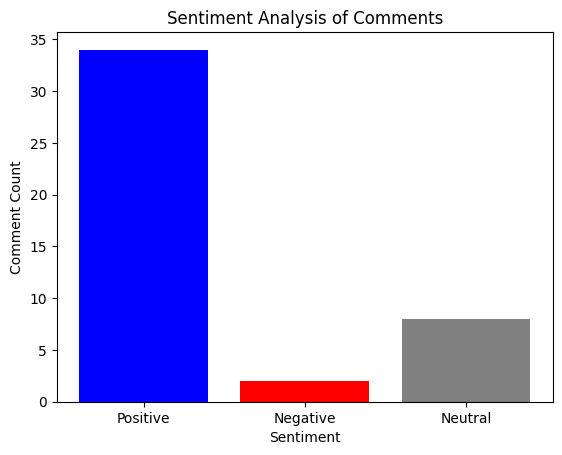

In [39]:
# Bar chart
plt.bar(['Positive', 'Negative', 'Neutral'], [positive_count, negative_count, neutral_count], color=['blue', 'red', 'grey'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

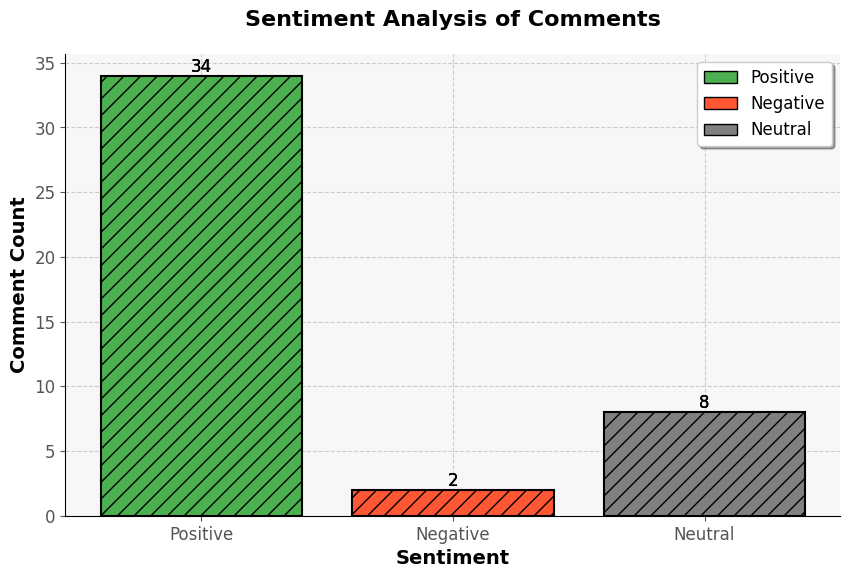

In [46]:
# Data
labels = ['Positive', 'Negative', 'Neutral']
comment_counts = [positive_count, negative_count, neutral_count]
colors = ['#4CAF50', '#FF5733', '#808080']  # Custom colors

# Creating the bar chart with more aesthetics
fig, ax = plt.subplots(figsize=(10, 6))

# Adding bar chart with custom colors
bars = ax.bar(labels, comment_counts, color=colors, edgecolor='black', linewidth=1.5)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.6)

# Adding shadow effect to the bars
for bar in bars:
    bar.set_zorder(3)
    ax.bar_label(bars, labels=[f'{int(count)}' for count in comment_counts], label_type='edge', fontsize=12, color='black')

# Adding a gradient effect manually
gradient = np.linspace(0.3, 1, 100)
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)
    bar.set_hatch('//')
    ax.bar(bar.get_x() + bar.get_width()/2, bar.get_height(), width=bar.get_width(), color=color, zorder=2, alpha=0.7)

# Customize the plot
ax.set_xlabel('Sentiment', fontsize=14, fontweight='bold')
ax.set_ylabel('Comment Count', fontsize=14, fontweight='bold')
ax.set_title('Sentiment Analysis of Comments', fontsize=16, fontweight='bold', pad=20)
ax.set_facecolor('#F7F7F7')  # Background color

# Customize ticks
ax.tick_params(axis='x', colors='#555555', labelsize=12)
ax.tick_params(axis='y', colors='#555555', labelsize=12)

# Remove spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend with custom handles
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors, labels)]
ax.legend(handles=legend_handles, loc='upper right', fontsize=12, frameon=True, shadow=True)

# Display the chart
plt.show()

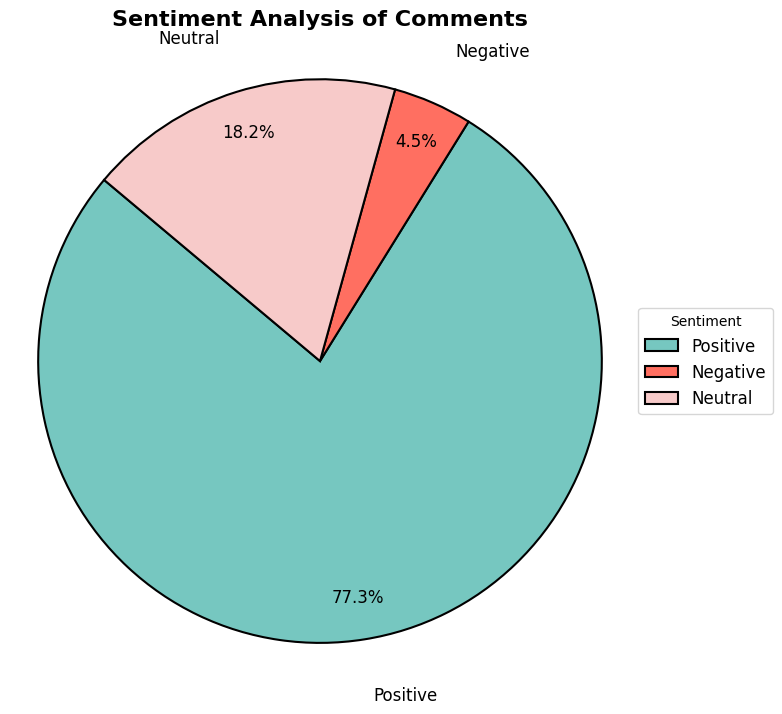

In [44]:
import matplotlib.pyplot as plt

labels = ['Positive', 'Negative', 'Neutral']
comment_counts = [positive_count, negative_count, neutral_count]
colors = ['#76C7C0', '#FF6F61', '#F7CAC9']

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(comment_counts, labels=labels, colors=colors, autopct='%1.1f%%',
                                  startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
                                  textprops={'fontsize': 12, 'color': 'black'}, pctdistance=0.85,
                                  labeldistance=1.2)

for text, autotext in zip(texts, autotexts):
    text.set_color('black')
    autotext.set_color('black')
    autotext.set_fontsize(12)

ax.axis('equal')
plt.title('Sentiment Analysis of Comments', fontsize=16, fontweight='bold', pad=20)
plt.legend(wedges, labels, title='Sentiment', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
plt.show()
